In [7]:
import os
import glob
import re
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import shutil
import random
%matplotlib inline

### configure your aws credentials to get writerights on S3

In [8]:
home = os.getcwd().split('AUT-CNN-TUB')[0]

# Image cerntering

In [9]:
def get_all_images_from_part(read_path, partname, extension):

    numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
    pats_path = [x.string for x in numbers if x is not None]

    if pats_path == []:
        print('ERROR: no directoris in path or wrong naming')
        SystemExit
        
    if partname not in pats_path:
        if type(partname) is str:
            print("ERROR: dir for this partnumber doesn't exists" )
            SystemExit
        else:
            partname = str(partname)
            
            if partname not in pats_path:
                print("ERROR: dir for this partnumber doesn't exists")
                SystemExit
                
    if extension  not in ['gif', 'jpeg', 'jpg', 'png', 'JPG']:
        print('ERROR: unknown extension')
        SystemExit
        
    else:
        data_path = os.path.join(os.path.join(read_path, partname), '*{}'.format(extension))
        files = glob.glob(data_path)
        return files

In [4]:
read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_industry/')

In [5]:
numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
[x.string for x in numbers if x is not None]

['2',
 '13',
 '14',
 '1',
 '7.1',
 '8',
 '5',
 '4',
 '3',
 '10',
 '12',
 '11',
 '6',
 '7.2',
 '15',
 '9']

In [45]:
files = get_all_images_from_part(read_path, 6, 'jpg')

In [62]:
for z,i in enumerate(files):
    if 'img75.' in i:
        print(i, z)

/home/jeronimo/git/AUT-CNN-TUB/Data/27072018/27072018_industry/6/img75.jpg 213


In [98]:
file_path = files[0]
img_name = file_path.split('/')[-1]  
image = cv2.imread(file_path)

### original

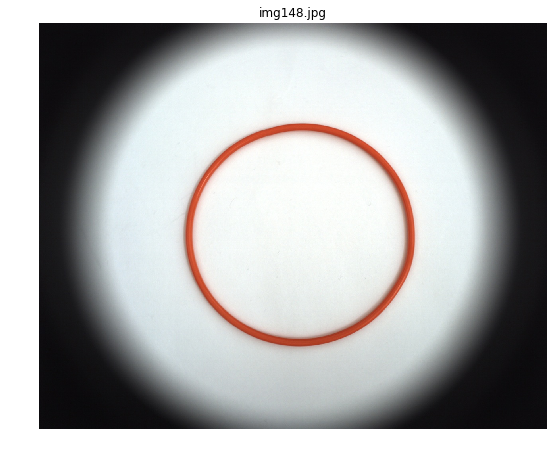

In [64]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#ax2 = fig.add_subplot(1, 2, 2)
#ax2.axis('off')
#ax2.set_title('Gaussian interpolation:\n' + file_path.split('/')[-1])
#ax2.imshow(image, cmap='gray', interpolation="gaussian");
plt.show()

### find sector

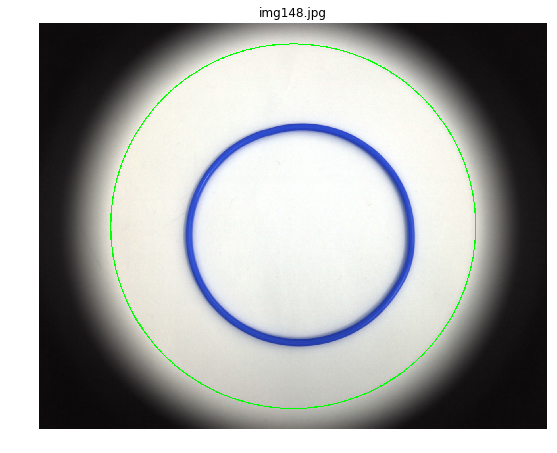

In [65]:
w, h, c = image.shape
image_copy = image.copy()
cv2.circle(image_copy,(int(h/2), int(w/2)),460,(0,255,0),2)
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(image_copy, cmap='gray');
#ax2 = fig.add_subplot(1, 2, 2)
#ax2.axis('off')
#ax2.set_title('Gaussian interpolation:\n' + file_path.split('/')[-1])
#ax2.imshow(image, cmap='gray', interpolation="gaussian");
plt.show()

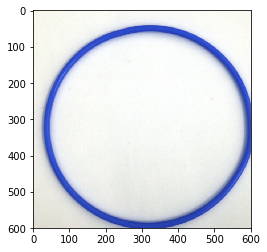

In [58]:
w, h, _ = image.shape
size = 600

image =image[int((w-size)/2): int((w-size)/2+size), int((h-size)/2):int((h-size)/2+size)]
plt.imshow(image)
plt.show()

### blurred

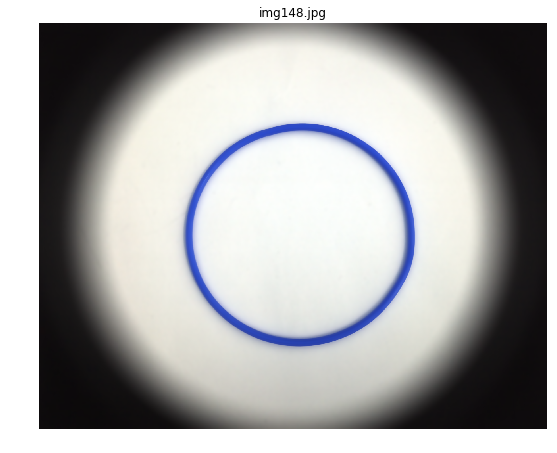

In [66]:
blurred = cv2.bilateralFilter(image,10, 100, 100)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(blurred)
plt.show()

### grayscale

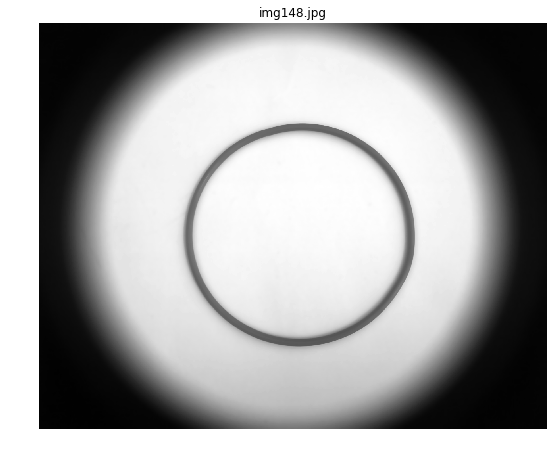

In [67]:
imgray = cv2.cvtColor(blurred,cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(imgray, cmap='gray');
plt.show()

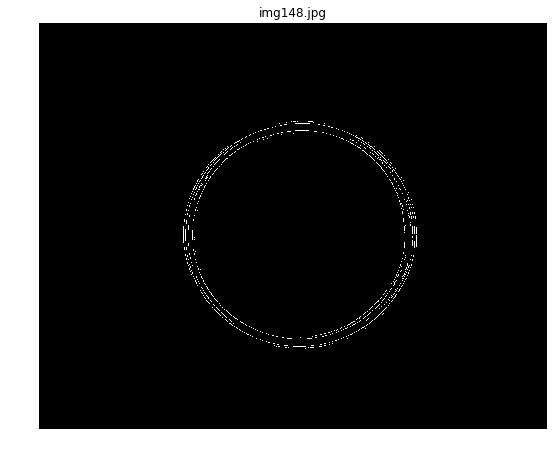

In [68]:
thresh = cv2.Canny(blurred,40,10)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(thresh, cmap='gray');
plt.show()

### findContours 

In [69]:
_,contours,_ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cnt = contours
contour_indexer = 0
i = 0
filteredContours = []
for c in cnt:
    if len(c) > 20:
        filteredContours.append(c)
    if len(filteredContours) > 0:
        merged_contours = np.concatenate(filteredContours)
    else:
        merged_contours = None

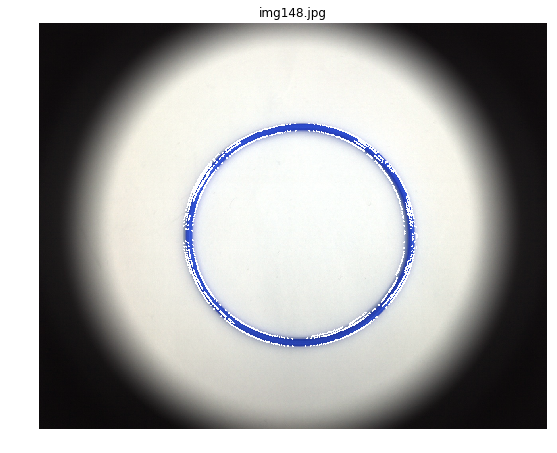

In [70]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(cv2.drawContours(image, merged_contours, -3, (255,255,255), 3), cmap='gray');
plt.show()

### fit in circle, to know where to cut

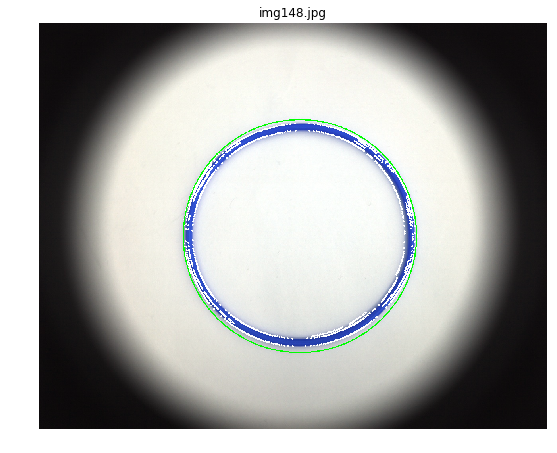

In [71]:
(x,y),radius = cv2.minEnclosingCircle(merged_contours)
center = (int(x),int(y))
radius = int(radius)
img = cv2.circle(image,center,radius,(0,255,0),2)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(img)
plt.show()

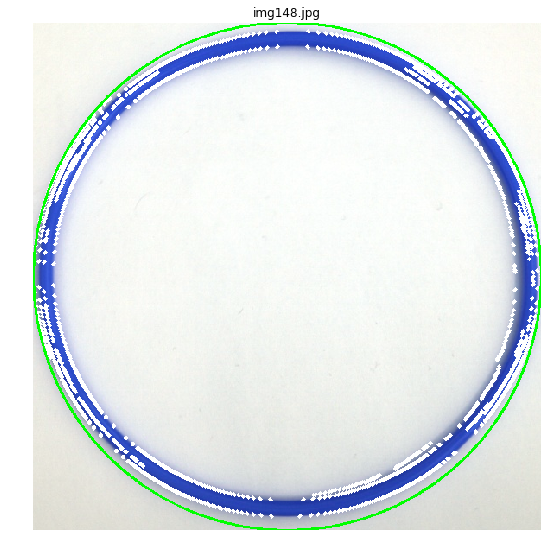

In [72]:
scale = 1.5
scaled_rad = radius * scale
try:
    img_cutted = image[center[1] - scaled_rad : center[1] + scaled_rad,
                       center[0] - scaled_rad : center[0] + scaled_rad,
                       : ] 
except:
    img_cutted = image[center[1] - radius : center[1] + radius,
                       center[0] - radius : center[0] + radius,
                       : ] 
    
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(1, 2, 1)
ax1.axis('off')
ax1.set_title(file_path.split('/')[-1])
ax1.imshow(img_cutted)
plt.show()

In [10]:
def get_part_from_image(image, scale = 1.1):
    
    #w, h, c = image.shape

    #a, b = w/2, h/2
    #r = 350
    #y,x = np.ogrid[-a:w-a, -b:h-b]
    #mask = x*x + y*y >= r*r
    #image[mask] = 255
    
    #w, h, _ = image.shape
    #size = 600

    #image =image[int((w-size)/2): int((w-size)/2+size), int((h-size)/2):int((h-size)/2+size)]
    
    blurred = cv2.bilateralFilter(image,10, 100, 100)
    imgray = cv2.cvtColor(blurred,cv2.COLOR_BGR2GRAY)
    thresh = cv2.Canny(blurred,40,10)
    _,contours,_ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    
    
    cnt = contours
    contour_indexer = 0
    i = 0
    filteredContours = []
    for c in cnt:
        if len(c) > 30:
            filteredContours.append(c)
    if len(filteredContours) > 0:
        merged_contours = np.concatenate(filteredContours)

        (x,y),radius = cv2.minEnclosingCircle(merged_contours)
        center = (int(x),int(y))
        radius = int(radius)
        scaled_rad = int(radius * scale)
        try:
            img_cutted = image[center[1] - scaled_rad : center[1] + scaled_rad,
                               center[0] - scaled_rad : center[0] + scaled_rad,
                               : ] 
        except:
            img_cutted = image[center[1] - radius : center[1] + radius,
                               center[0] - radius : center[0] + radius,
                               : ] 

        return img_cutted
    else:
        return None

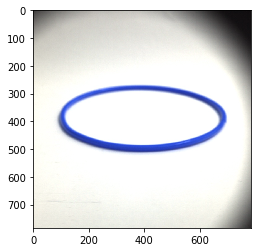

In [99]:
plt.imshow(get_part_from_image(image, scale = 1.3))
plt.show()

0 /home/jeronimo/git/AUT-CNN-TUB/Data/Raw_Data_27072018_industry/6/06.0.0.2.0114.jpg


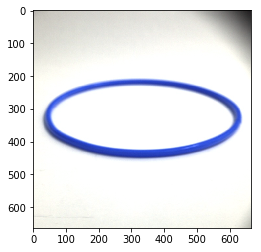

1 /home/jeronimo/git/AUT-CNN-TUB/Data/Raw_Data_27072018_industry/6/06.0.0.0.0075.jpg


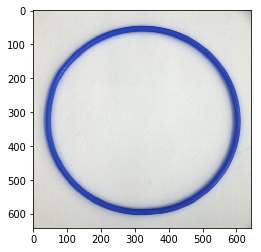

2 /home/jeronimo/git/AUT-CNN-TUB/Data/Raw_Data_27072018_industry/6/06.0.0.2.0238.jpg


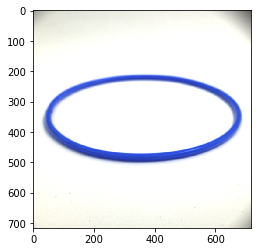

3 /home/jeronimo/git/AUT-CNN-TUB/Data/Raw_Data_27072018_industry/6/06.0.0.0.0193.jpg


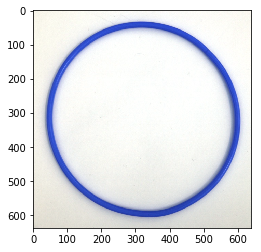

4 /home/jeronimo/git/AUT-CNN-TUB/Data/Raw_Data_27072018_industry/6/06.0.0.2.0115.jpg


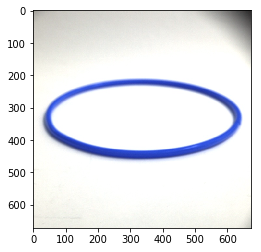

5 /home/jeronimo/git/AUT-CNN-TUB/Data/Raw_Data_27072018_industry/6/06.0.0.0.0043.jpg


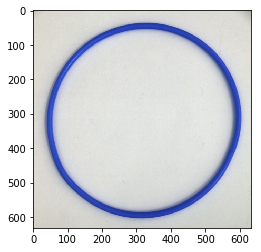

6 /home/jeronimo/git/AUT-CNN-TUB/Data/Raw_Data_27072018_industry/6/06.0.0.0.0190.jpg


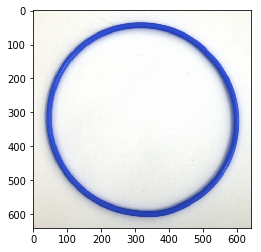

7 /home/jeronimo/git/AUT-CNN-TUB/Data/Raw_Data_27072018_industry/6/06.0.0.1.0231.jpg


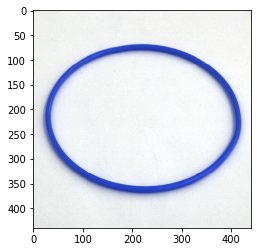

8 /home/jeronimo/git/AUT-CNN-TUB/Data/Raw_Data_27072018_industry/6/06.0.0.1.0134.jpg


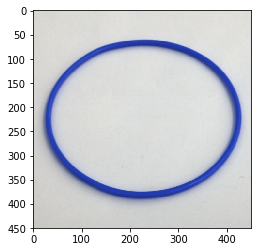

9 /home/jeronimo/git/AUT-CNN-TUB/Data/Raw_Data_27072018_industry/6/06.0.0.2.0144.jpg


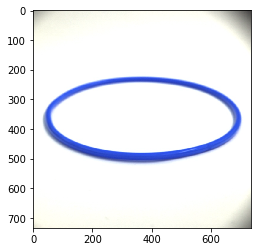

In [100]:
files = get_all_images_from_part(read_path, 6, 'jpg')
for i, file_path in enumerate(files[:10]):
    image = cv2.imread(file_path)
    print(i,file_path)
    try:
        plt.imshow(get_part_from_image(image))
        plt.show()
    except:
        print('ERROR')

### genrate folder whith cerndered and well shaped images

In [111]:
new_size = 200

home = os.getcwd().split('AUT-CNN-TUB')[0]
read_path = os.path.join(home,'AUT-CNN-TUB/Data/Raw_Data_27072018_industry/')
write_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_industry_centered_{}x{}/'.format(new_size, new_size))

extension = 'jpg'

numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])

for part_nr in [x.string for x in numbers if x is not None]:
    for file_path in get_all_images_from_part(read_path, part_nr, extension):
        img_name = file_path.split('/')[-1].replace('.jpg','')
        image = cv2.imread(file_path)

        img_centerd = get_part_from_image(image)
        if img_centerd is not None:
            try:
                img_resized = cv2.resize(img_centerd,(new_size, new_size))
            except:
                print('Image {}.jpg is to small.'.format(img_name))
                img_resized = None
                
            part_patch =os.path.join(write_path, part_nr)
            
            if img_resized is not None:
                if img_resized.var() > 1000:
                    if os.path.exists(part_patch):
                        cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)
                    else:
                        os.makedirs(part_patch)
                        cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)
                else:
                    print('Image {}.jpg does not have the necessary variance.'.format(img_name))


Image 02.0.0.1.0375.jpg is to small.


KeyboardInterrupt: 

### downscale

In [102]:
new_size = 100

home = os.getcwd().split('AUT-CNN-TUB')[0]
read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_industry_centered_200x200/')
write_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_industry_centered_{}x{}/'.format(new_size, new_size))

extension = 'jpg'

numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
for part_nr in [x.string for x in numbers if x is not None]:
    for file_path in get_all_images_from_part(read_path, part_nr, extension):
        img_name = file_path.split('/')[-1].replace('.jpg','')
        image = cv2.imread(file_path)

        try:
            img_resized = cv2.resize(image,(new_size, new_size))
        except:
            print('Image {}.jpg is to small.'.format(img_name))
        
        part_patch =os.path.join(write_path, part_nr)
            
        if os.path.exists(part_patch):
            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)
        else:
            os.makedirs(part_patch)
            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)

In [105]:
new_size = 50

home = os.getcwd().split('AUT-CNN-TUB')[0]
read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_industry_centered_200x200/')
write_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_industry_centered_{}x{}/'.format(new_size, new_size))

extension = 'jpg'

numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
for part_nr in [x.string for x in numbers if x is not None]:
    for file_path in get_all_images_from_part(read_path, part_nr, extension):
        img_name = file_path.split('/')[-1].replace('.jpg','')
        image = cv2.imread(file_path)

        try:
            img_resized = cv2.resize(image,(new_size, new_size))
        except:
            print('Image {}.jpg is to small.'.format(img_name))
        
        part_patch =os.path.join(write_path, part_nr)
            
        if os.path.exists(part_patch):
            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)
        else:
            os.makedirs(part_patch)
            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)

In [104]:
new_size = 28

home = os.getcwd().split('AUT-CNN-TUB')[0]
read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_industry_centered_200x200/')
write_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_industry_centered_{}x{}/'.format(new_size, new_size))

extension = 'jpg'

numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
for part_nr in [x.string for x in numbers if x is not None]:
    for file_path in get_all_images_from_part(read_path, part_nr, extension):
        img_name = file_path.split('/')[-1].replace('.jpg','')
        image = cv2.imread(file_path)

        try:
            img_resized = cv2.resize(image,(new_size, new_size))
        except:
            print('Image {}.jpg is to small.'.format(img_name))
        
        part_patch =os.path.join(write_path, part_nr)
            
        if os.path.exists(part_patch):
            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)
        else:
            os.makedirs(part_patch)
            cv2.imwrite(os.path.join(part_patch, '{}.{}'.format(img_name, extension)), img_resized)

### summarize

In [106]:
read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_industry_centered_28x28/')

numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
print('Images in File:')
for part_nr in [x.string for x in numbers if x is not None]:
    print('{}\t{}'.format(len(os.listdir(os.path.join(read_path, part_nr))), part_nr))


Images in File:
1066	2
1075	13
987	14
1160	1
1079	7.1
1271	8
1114	5
911	4
775	3
1047	10
1087	12
773	11
775	6
1047	7.2
1059	15
948	9


In [25]:
size = 28
read_path = os.path.join(home,'AUT-CNN-TUB/Data/27072018/27072018_canon_centered_{}x{}/'.format(size, size))
path_length   = len(read_path) 
test_path  = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_merge_{}/test/'.format(size, size))
train_path = os.path.join(home,'AUT-CNN-TUB/Data/TF_Images_merge_{}/train/'.format(size, size))

ratio=0.7
img_path=read_path
GRBtoGray = False
extension = 'jpg'


numbers = filter(None, [re.match('\d+',f) for f in  os.listdir(read_path)])
for part_nr in [x.string for x in numbers if x is not None]:
    
    files = get_all_images_from_part(read_path, part_nr, extension)            
    num_imag     = len(files)
    breakpoint   = int(np.round(ratio*num_imag)) 
    Data         = np.arange(0,num_imag)            
    random.shuffle(Data)  
    DataTrain    = Data[:breakpoint]              
    DataTest     = Data[breakpoint:]              
    
    if os.path.exists(test_path) is False:
        os.makedirs(test_path)
        
    if os.path.exists(train_path) is False:
        os.makedirs(train_path)
    
    for i,f1 in enumerate(files):
        img_name = f1.split('/')[-1]        

        img = cv2.imread(f1)
        if(GRBtoGray == True):
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)      


        if(i in DataTrain):
            cv2.imwrite(train_path + img_name, img)  
        if(i in DataTest):
            cv2.imwrite(test_path + img_name, img)  

### save zip on S3

In [ ]:
import boto3
import botocore

s3 = boto3.resource('s3')
bucket = s3.Bucket('imagesforcnn')

for bucket in s3.buckets.all():
    print(bucket.name)
        
for object in s3.Bucket('imagesforcnn').objects.all():
    print(object)

In [ ]:
# zip dir 
from_dir = os.path.join(home,'AUT-CNN-TUB/Data/Centered/')
to_dir = os.path.join(home,'AUT-CNN-TUB/Data/Centered')

shutil.make_archive(to_dir,
                    'zip',
                    from_dir
                    )

In [ ]:

path = os.path.join(home,'AUT-CNN-TUB/Data/')

from_dir = os.path.join(home,'AUT-CNN-TUB/Data/Centered')
to_dir = os.path.join(home,'AUT-CNN-TUB/Data/')
filename = 'Centered'

extension = 'zip'

if extension is 'zip':
    shutil.make_archive(os.path.join(os.path.join(to_dir, filename)), extension, from_dir)

# Upload a new file
data = open(os.path.join(to_dir, filename + '.{}'.format(extension)), 'rb')
print('uploading {}.{} ... '.format(filename, extension), end='\r')
bucket.put_object(Key=filename + '.{}'.format(extension), Body=data)
print('uploading {}.{} finished'.format(filename, extension))
